# Exam Project spring 2020

In [ ]:
from itertools import product
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import linalg
import sympy as sm
from scipy.stats import norm # normal distribution

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')
import seaborn as sns

%load_ext autoreload
%autoreload 2

# Linear Regression

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

In [3]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

# Question 1:


We have that $\hat{\beta}=(X'X)^{-1}X'y$. Firstly we define the matrices in the equation. We define the functions and vector, in order to be able to estimate the beta vectors.

In [4]:
# a: defining functions to make a column of 1s in X
ones = np.ones(len(x1))

# b: defining X vector by stacking ones_column, x1 and x2
X = np.column_stack((ones,x1,x2))


# c: defining X_prime, X_prime_X and X_prime_X_inv
X_prime = X.T
X_prime_X = X_prime@X
X_prime_X_inv = linalg.inv(X_prime_X)

We can now estimate the beta values:

In [5]:
# Solving beta_hat

beta_hat = X_prime_X_inv@X_prime@y
print(f'The fitted values for beta are equal to {beta_hat}')

The fitted values for beta are equal to [0.0956821  0.29294299 0.50332771]


# Question 2:

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$.

We construct a 3D plot, where the data has been plotted as scattered points. We define the $\hat{y}(x_1,x_2,\hat{\beta}_0,\hat{\beta}_1,\hat{\beta}_2)$ function, where we estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$


In [6]:
#defining beta_hat values
beta_0_hat = 0.0956821
beta_1_hat = 0.29294299
beta_2_hat = 0.50332771

#defining y_hat as a function
def y_hat(x1,x2,beta_0_hat,beta_1_hat,beta_2_hat):
    return beta_0_hat+beta_1_hat*x1+beta_2_hat*x2

#defining y_hat as a vector
y_hat_vec = y_hat(x1,x2,beta_0_hat,beta_1_hat,beta_2_hat)

#defining x1_values and x2_values
x1_values = x1
x2_values = x2

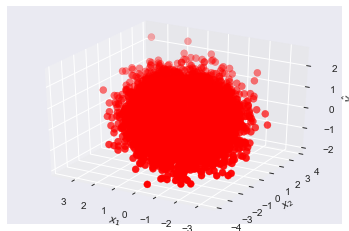

In [7]:
#Plotting figure

# a. actual plot
fig = plt.figure() 
ax = fig.add_subplot(1,1,1,projection='3d') 
ax.scatter(x1_values,x2_values,y_hat_vec,s=50,color='red');

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$\hat{y}$')

# c. invert xaxis
ax.invert_xaxis()

# d. show
plt.show()

# Question 3:

Estimate the vector of coefficients $\hat{\beta}=(\beta_0,\beta_1,\beta_2)$ using a numerical solver to solve the OLS problem shown below. 

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In the function below we define the function f, which returns the minimization problem stated above. 

In [8]:
# a: define the function with thw coefficents 
def f(coefficients):
    beta0,beta1,beta2=coefficients
    return sum((y-(beta0+beta1*x1+beta2*x2))**2)

# b: inital guess 
initial_guess=[1, 1, 1]

# c: optimizing the function f, to estimate the fitted values. 
result=optimize.minimize(f,initial_guess, method = 'Nelder-Mead')
fitted_values = result.x

In [9]:
fitted_values

array([0.0956629 , 0.29291419, 0.50334836])

The $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ is estimated as $\mathbf{\beta}=(0.095, 0.29, 0.50)$, which is equivilent to the values estimated in question 1. 

# Question 4:
We estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem : 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

We once again define the function, but now we wish to estimate the coefficents using LAD. 

In [10]:
def f_abs(coefficients):
    beta0,beta1,beta2=coefficients
    return sum(abs((y-(beta0+beta1*x1+beta2*x2))))
    
initial_guess=[1, 1, 1]
result_abs=optimize.minimize(f_abs,initial_guess, method = 'Nelder-Mead')
fitted_abs_values = result_abs.x

In [11]:
fitted_abs_values

array([0.09226645, 0.30745194, 0.51153822])

The estimates, when estimated with LAD, are $\mathbf{\beta} = (0.092, 0.30, 0.51)$

# Question 5:

To be able to estimate the coefficents, we implement Monte Carlo. We constructed two vectors, one containing the beta estimates from OLS and the other containing the LAD estimates. 

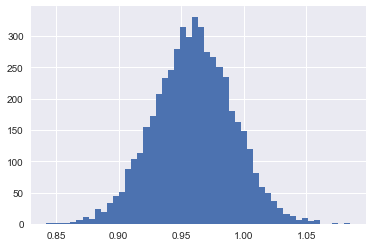

In [44]:
#Setting up Monte Carlo simultation for OLS
K = 5000 
N = 50
vector_beta_ols= []
for i in range(K): 
    x_vector  =  np.random.normal(0,1,1000)
    x = np.array([x_vector])
    y_vector = (beta*x) + np.random.normal(0,1,1000)
    y = np.array(y_vector)
    var_x_ols = np.dot(x,x.T)
    covar_xy_ols = np.dot(x,y.T)
    Matrix_inv_ols = np.linalg.inv(var_x_ols)
    beta_estimated_ols =  np.dot(Matrix_inv_ols,covar_xy_ols)
    vector_beta_ols.append(beta_estimated_ols)

#Plotting estimated betas from the Monte Carlo simulation in a histogram
NpArray_vector_beta_ols = np.array(vector_beta_ols)
vector_beta_ols_hist = NpArray_vector_beta_ols.ravel()
plt.hist(vector_beta_ols_hist ,  bins=50)
plt.show()

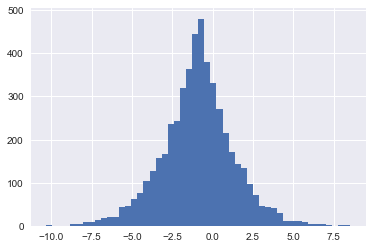

In [45]:
#Setting up Monte Carlo simultation
K = 5000 
N = 50
vector_beta_lad= []
for i in range(K): 
    x_vector  =  np.random.normal(0,1,1000)
    x = np.array([x_vector])
    y_vector = sum(abs((y-(beta*x)))) + np.random.normal(0,1,1000)
    y = np.array(y_vector)
    var_x_lad = np.dot(x,x.T)
    covar_xy_lad = np.dot(x,y.T)
    Matrix_inv_lad = np.linalg.inv(var_x_lad)
    beta_estimated_lad =  np.dot(Matrix_inv_lad,covar_xy_lad)
    vector_beta_lad.append(beta_estimated_lad)

#Plotting estimated betas from the Monte Carlo simulation in a histogram
NpArray_vector_beta_lad = np.array(vector_beta_lad)
vector_beta_lad_hist = NpArray_vector_beta_lad.ravel()
plt.hist(vector_beta_lad_hist ,  bins=50)
plt.show()

The difference between the **OLS** and **LAD** is that OLS estimates the coefficients that minimise the sum of squared residuals, LAD estimates the coefficients that minimises the sum of the absolute residuals.

When comparing the two estimates, we wish to use the OLS estimates, given that the distribution of OLS is approximately more normally distributed than the distribution of the LAD estimates. 
We wanted to plot the normal distribution in the histograms to show, which of the estimation methods would compute the most normally distributed estimates. However, as the density of the normal distribution does not match up with th density of plots, we were not able to illustrate it, in a helpful way. 

# Durable Purchases

In [14]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
chi=0.9
r = 0.04
Delta = 0.25

# b. vectors 
v2_vec = np.empty(100)
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

In the section below, we wish to define the functions we use to answer the questions below. 

In [15]:
# a: The utility function
def utility(c,d,x,chi,alpha,rho):
    return ((c**alpha*(d+chi*x)**(1-alpha))**(1-rho))/(1-rho)

# b: The extra durable consumption 
def extra_durable_consumption(m,c):
    return m-c

# c: The houeseholds value of having cash on hand in period 2
def v2(c,m2,d,chi,alpha,rho):
    
    x = extra_durable_consumption(m2,c)
    return utility(c,d,x,chi,alpha,rho)

# d: utility weight on non durable consumption 
def assets(m,d):
    return m-d

When defining the value function for the first period ($v_1(m_1)$), we firstly need to define a function w(a,d), which measures the expected value of $v_2(m_2,d)$, that is the household's value of having $m_2$ at the beginning of period 2. Here we take in to account, that the value of $m_2$ depends on the probability distribution of y. 

In [16]:
def w(a,r,Delta):
    
    # a. v2 value, if low income
    m2_low = (1+r)*a + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if medium income
    m2_medium = (1+r)*a + 1
    v2_medium = v2_interp([m2_medium])[0]
    
    # c. v2 value, if high income
    m2_high = (1+r)*a + 1 + Delta
    v2_high = v2_interp([m2_high])[0]
    
    # d. expected v2 value
    v2 = 0.333*v2_low + 0.333*v2_medium + 0.333*v2_high

    # e. total value
    return beta*v2

In [17]:
# Defining the value function for period 1 
def v1(m1,d,beta,r,Delta,v2_interp):
    
    a=assets(m1,d)
    
    return w(a,r,Delta)

In [18]:
# Defining the solve function for period 1
def solve_period_2(rho,alpha,Delta,chi):

    # a. grids
    v2_grid= np.empty((100,100))
    c_grid = np.empty((100,100))

    # b. solve for each m2
    for i, m2 in enumerate(m2_vec):
        for j, d in enumerate(d_vec):

            # i. objective
            obj = lambda c: -v2(c,m2,d,chi,alpha,rho)

            # ii. initial value
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c_grid[i,j] = result.x
        
    return m2_vec,d_vec,v2_grid,c_grid

# Question 1: plotting the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$

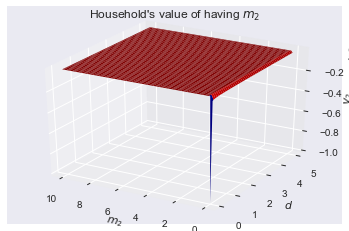

In [19]:
# a. solve
m2_vec,d_vec,v2_grid,c_grid = solve_period_2(rho,alpha,Delta,chi)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_grid,cmap=cm.jet)

# d. add labels
ax.set_title("Household's value of having $m_2$")
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v_2$')
ax.invert_xaxis()

In the above we see a plot of $v_2$ against $m_2$ and d. From the plot it is evident, that the household's value of having cash-on-hand in the beginning of period 2 is zero for all values of $m_2$ and d, with the exception of the latter two being equal to zero. When this is the case the household's value of having cash-on-hand in the beginning of period 2 is negative. 

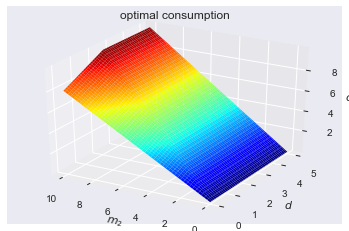

In [20]:
# a. solve
m2_vec,d_vec,v2_grid,c_grid = solve_period_2(rho,alpha,Delta,chi)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c_grid,cmap=cm.jet)

# d. add labels
ax.set_title("optimal consumption")
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c$')
ax.invert_xaxis()

The optimal choice of non-durable consumption is rising in the cash-on-hand in the beginning of period 2, for any given value of the pre-commited durable consumption. 

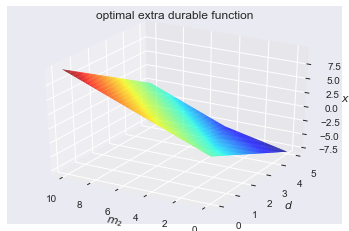

In [21]:
m2_vec,d_vec,v2_grid,c_grid = solve_period_2(rho,alpha,Delta,chi)
x_vec = m2_vec - c_grid
d_grid,m2_grid = np.meshgrid(d_vec,m2_vec,indexing='ij')

# creating figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_surface(m2_grid,d_grid,x_vec,cmap=cm.jet)

# adding title and labels
ax.set_title("optimal extra durable function")
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$x*$')

# inverting the axis
ax.invert_xaxis()

For rising values of $m_2$ and declining values of d, the extra durable consumption is rising. It seems that the most optimal value, is when the household has rising cash on hand in the end of period 2. Their is a negative relationship between the pre-comitted durable consumption and the extra durable consumption. 

# Question 2: Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

In [23]:
v2_interp=interpolate.RegularGridInterpolator([m2_vec],v2_vec,bounds_error=False,fill_value=None)

In [39]:
def solve_period_1(r,beta,Delta,v1,v2_interp):
    
    # a. grids
    m1_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    v1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda d: -v1(m1,d,beta,r,Delta,v2_interp)
        
        # ii. initial guess
        x0 = 0.333*m1
        
        # iv. optimize
        result = optimize.minimize_scalar(obj,x0, method='bounded',bounds=[1e-8,m1])

        
        # v. save
        v1_vec[i] = -result.fun
        d_vec[i] = result.x
     
    return m1_vec,d_vec,v1_vec    

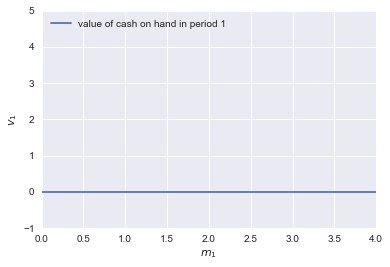

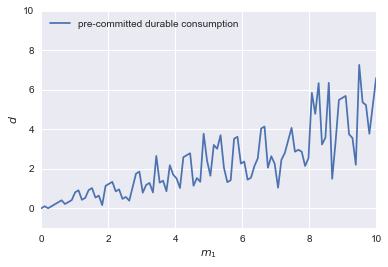

In [43]:
# c. solve period 1
m1_vec,d_vec,v1_vec = solve_period_1(r,beta,Delta,v1,v2_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,v1_vec,label='value of cash on hand in period 1')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_xlim([0,4])
ax.set_ylim([-1,5]);

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,d_vec,label='pre-committed durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$d$')
ax.set_xlim([0,10])
ax.set_ylim([-1,10]);

The above plots are supposed to show the value of cash on hand in period 1 and pre-committed durable consumption, respectively. 
But as can be seen from above, the results are non-rational. 

# Gradient descent 

To be able to define the gradient_decent() algoritm, we implement the following ten steps. First and foremost, we choose a tolerance, a scale factor (Theta) and a small number (Delta), all of which are above zero. 

In [36]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10000):
    
    # step 2: guess on x0 and set n=1
    x_n = x0
    n = 1
    delta_1 = np.array([Delta,0])
    delta_2 = np.array([0,Delta])
    
    
    while True:
        # step 3: Computing a numerical approximation of the jacobian for f by 
        jacobi = 1/Delta*np.array([f(x_n+delta_1)-f(x_n),f(x_n+delta_2)-f(x_n)])


        # step 4: stop if the maximum element in |Delta*f(xn_1)| is less than the tolerance level 
        if np.max(np.absolute(jacobi)) < epsilon:
            break
       
        # step 5: Set theta=Theta 
        theta = Theta
        while True:
    
        # step 6: Computing fn_theta = f(xn_1-theta*f(xn_1))
            fn_theta = f(x_n-theta*jacobi)
        
        # step 7: if fn_theta < f(xn_1) continue to step 9 
            if fn_theta < f(x_n):
                break
                
        # step 8: set theta = theta/2
            theta = theta/2
            
        # step 9: set x_n=x_n - theta*jacobi
        x_n = x_n - theta * jacobi
        
        # step 10: set n=n+1 and return to step 3
        n += 1
        
    return x_n, n

In [37]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

minimum found at (1.0000,1.0000) after 306 iterations
